<a href="https://colab.research.google.com/github/hin1799/Advanced-Machine-Learning/blob/main/AML_Reproducibility_Challenge_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning

# Reproducibility Report on the paper:

# **Predict then Interpolate: A Simple Algorithm to Learn Stable Classifiers**

## Code Implementation

**Submitted By**

1. Jigar Shekhat (202211004)
2. Jainisha Choksi (202211019)
3. Hinal Desai (202211035)
4. Man Desai (202211040)
5. Rutvik Prajapati (202211053)

For the code implementation of this paper, GPU is required. Hence we have connected the Google Compute Engine backend from the Google Colab resources.

**Checking if GPU is initialized**

In [1]:
!nvidia-smi

Tue Apr 25 14:48:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Checking if cuda is available through PyTorch**

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
print(torch.__version__)

2.0.0+cu118


# Required Imports

In [4]:
from termcolor import colored
import torch
import numpy as np
import random
from collections import defaultdict
from torchvision import datasets
from torch.utils.data import Dataset
from torch.distributions.categorical import Categorical
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchsummary import summary
from torch.utils.data import Sampler
import copy
import datetime
from termcolor import colored
from tqdm import tqdm
from torch.utils.data import DataLoader


# Helper Functions

The following code contains the helper functions that are required for running the code.

Function **to_cuda()** is used to move the tensors stored as values in the dictionary d to the GPU.

In [5]:
def to_cuda(d):
    for k, v in d.items():
        d[k] = v.cuda()

    return d

Removing unnecessary batch dimension from each value in the input dictionary batch.

In [6]:
def squeeze_batch(batch):
    res = {}
    for k, v in batch.items():
        assert len(v) == 1
        res[k] = v[0]

    return res

Helper function to print the training and validation results for a specific epoch.

In [7]:
def print_res(train_res, val_res, ep):
    print(("epoch {epoch}, train {acc} {train_acc:>7.4f} "
           "{loss} {train_loss:>10.7f}, {regret} {train_regret:>10.7f} "
           "val {acc} {val_acc:>10.7f}, {loss} {val_loss:>10.7f}").format(
               epoch=ep,
               acc=colored("acc", "blue"),
               loss=colored("loss", "yellow"),
               regret=colored("regret", "red"),
               train_acc=train_res["acc"],
               train_loss=train_res["loss"],
               train_regret=train_res["regret"],
               val_acc=val_res["acc"],
               val_loss=val_res["loss"]), flush=True)

Calculate the worst case accuracy of the model's predictions on dataset with attribute-based labels.

In [8]:
def get_worst_acc(true, pred, idx, loss, att_idx_dict):
    acc_list = (true == pred).float().tolist()
    idx = torch.cat(idx).tolist()
    idx_origin2new = dict(zip(idx, range(len(idx))))

    verbose = True
    if len(att_idx_dict) == 1:  # validation
        verbose = False

    worst_acc_list = []
    avg_acc_list = []

    for att, data_dict in att_idx_dict.items():
        if verbose:
            print('{:>20}'.format(att), end=' ')

        worst_acc = 1
        avg_acc = []
        for k, v in data_dict.items():
            # value to index mapping
            acc = []
            for origin in v:
                acc.append(acc_list[idx_origin2new[origin]])

            if len(acc) > 0:
                cur_acc = np.mean(acc)

                if verbose:
                    print(k, ' {:>8}'.format(len(v)),
                          ' {:>7.4f}'.format(cur_acc), end=', ')
                if cur_acc < worst_acc:
                    worst_acc = cur_acc
                avg_acc.append(cur_acc)

        if verbose:
            print(' worst: {:>7.4f}'.format(worst_acc))

        avg_acc = np.mean(avg_acc)
        worst_acc_list.append(worst_acc)
        avg_acc_list.append(avg_acc)

    return {
        'acc': np.mean(worst_acc_list),
        'avg_acc': np.mean(avg_acc_list),
        'loss': loss,
    }


# Dataset

Currently, we have implemented the code for MNIST dataset. So the following code blocks contain the code for Colored MNIST dataset which is an extension of MNIST to make the multi-class classification problem more challenging.

The class ColoredMNIST loads the MNIST dataset from PyTorch and creates environments for it.

**init**: initializes the dataset. Creates per class data dictionary where key represents the class label and value represents list of samples with that label.

Data is split into four environments. Different levels of label corruption for each environment specified by the **envs** dictionary.

**make_environment**: creates new environment with given images, labels and label corruption probability. Applies label and color corruption to the data.

**get_item**: returns dictionary containing images, labels, and color for given set of indices and environment.

**get_all_y** and **get_all_c**: return the label and color values for each environment.

In [9]:
#class for ColoredMNIST dataset
class ColoredMNIST(Dataset):
    def __init__(self, file_path, is_train, val, env0=None, env1=None):
        print('Load data')
        mnist = datasets.MNIST(file_path, train=is_train, download=True)

        print('Create per class data dictionary')

        self.data = defaultdict(list)
        label_dict = dict(zip(list(range(10)), list(range(10))))

        for x, y in zip(mnist.data, mnist.targets):
            if int(y) in label_dict:
                self.data[label_dict[int(y)]].append(x)

        # shuffle data
        self.length = 0
        random.seed(0)
        for k, v in self.data.items():
            random.shuffle(v)
            self.data[k] = torch.stack(v, dim=0)
            self.length += len(self.data[k])

        # make environments for each env
        # env 0: 0.1, env 1: 0.2, env 3: 0.9
        envs = {
            0: 0.1,
            1: 0.2,
            2: -1,
            3: 0.9,
        }

        if val == 'in_domain':  # use train env for validation
            envs[2] = envs[1]
        else:  # use test env for validation
            envs[2] = envs[3]

        self.envs = {}
        for i in range(4):
            images = []
            labels = []
            for j in range(10):
                start = i*(len(self.data[j])//len(envs))
                end = (i+1)*(len(self.data[j])//len(envs))

                images.append(self.data[j][start:end])
                labels.append((torch.ones(end-start) * j).long())

            images = torch.cat(images, dim=0)
            labels = torch.cat(labels, dim=0)

            self.envs[i] = self.make_environment(images, labels, envs[i])

        self.data_idx = {
            0: self.envs[0]['idx_dict'],
            1: self.envs[1]['idx_dict'],
            2: self.envs[2]['idx_dict'],
            3: self.envs[3]['idx_dict'],
        }

        # not evaluating worst-case performance of mnist
        self.val_att_idx_dict = None
        self.test_att_idx_dict = None


    def __len__(self):
        return self.length

    @staticmethod
    def make_environment(images, labels, e):
        # different from the IRM repo, here the labels are already binarized
        images = images.reshape((-1, 28, 28))

        # change label with prob 0.25
        prob_label = torch.ones((10, 10)).float() * (0.25 / 9)
        for i in range(10):
            prob_label[i, i] = 0.75

        labels_prob = torch.index_select(prob_label, dim=0, index=labels)
        labels = Categorical(probs=labels_prob).sample()

        # assign the color variable
        prob_color = torch.ones((10, 10)).float() * (e / 9.0)
        for i in range(10):
            prob_color[i, i] = 1 - e

        color_prob = torch.index_select(prob_color, dim=0, index=labels)
        color = Categorical(probs=color_prob).sample()

        # Apply the color to the image by zeroing out the other color channel
        output_images = torch.zeros((len(images), 10, 28, 28))

        idx_dict = defaultdict(list)
        for i in range(len(images)):
            idx_dict[int(labels[i])].append(i)
            output_images[i, color[i], :, :] = images[i]

        cor = color.float()

        idx_list = list(range(len(images)))

        return {
            'images': (output_images.float() / 255.),
            'labels': labels.long(),
            'idx_dict': idx_dict,
            'idx_list': idx_list,
            'cor': cor,
        }

    def __getitem__(self, keys):
        idx = []
        if len(keys[0]) == 2:
            # without reindexing y
            idx = []
            for key in keys:
                env_id = int(key[1])
                idx.append(key[0])

            return {
                'X': self.envs[env_id]['images'][idx],
                'Y': self.envs[env_id]['labels'][idx],
                'C': self.envs[env_id]['cor'][idx],
                'idx': torch.tensor(idx).long(),
            }

    def get_all_y(self, env_id):
        return self.envs[env_id]['labels'].tolist()

    def get_all_c(self, env_id):
        return self.envs[env_id]['cor'].tolist()

Load data


100%|██████████| 9912422/9912422 [00:00<00:00, 225137605.02it/s]

Extracting path/to/mnist/MNIST/raw/train-images-idx3-ubyte.gz to path/to/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35203630.87it/s]


Extracting path/to/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to path/to/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70148000.78it/s]

Extracting path/to/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to path/to/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4420076.28it/s]


Extracting path/to/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to path/to/mnist/MNIST/raw

Create per class data dictionary


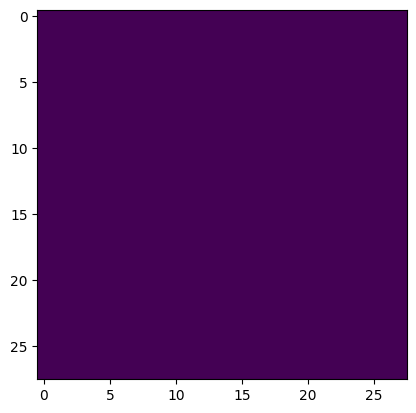

In [10]:
dataset = ColoredMNIST(file_path='path/to/mnist', is_train=True, val='in_domain')
image = dataset[[(0, 0)]]['X'][0][0]

pil_image = ToPILImage()(image)
plt.imshow(pil_image)
plt.show()


Loading and splitting the dataset into train and test.

In [11]:
def get_dataset(data_name, val_type):
    if data_name == 'MNIST':
        train_data = ColoredMNIST('./datasets/mnist', is_train=True,
                                  val=val_type)
        test_data = ColoredMNIST('./datasets/mnist', is_train=False,
                                 val=val_type)

        return train_data, test_data

train_data, test_data = get_dataset("MNIST", "in_domain")

Load data


100%|██████████| 9912422/9912422 [00:00<00:00, 165316237.67it/s]

Extracting ./datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 101284024.94it/s]


Extracting ./datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 66491283.67it/s]

Extracting ./datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17558091.03it/s]


Extracting ./datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/mnist/MNIST/raw

Create per class data dictionary
Load data
Create per class data dictionary


In [12]:
type(train_data)

__main__.ColoredMNIST

# Model

The following code blocks contain the functions required for creating the model using Convolutional Neural Networks and Multi Layer Perceptron.

## CNN

In [13]:
class CNN(nn.Module):
    def __init__(self, include_fc, hidden_dim):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(10, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(9216, hidden_dim)

        self.include_fc = include_fc
        if self.include_fc:
            self.out_dim = hidden_dim
        else:
            self.out_dim = 9216

    def forward(self, input):
        x = input.view(input.shape[0], 10, 28, 28)

        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        if self.include_fc:
            x = self.fc1(x)
            x = F.relu(x)

        return x

In [14]:
# Create an instance of the CNN model
model = CNN(include_fc=True, hidden_dim=128).cuda()

#Displaying the summary for CNN model
summary(model, input_size=(1, 10, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           2,912
            Conv2d-2           [-1, 64, 24, 24]          18,496
         Dropout2d-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
Total params: 1,201,184
Trainable params: 1,201,184
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.13
----------------------------------------------------------------


## MLP

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout, depth=1):
        super(MLP, self).__init__()

        modules = [nn.Dropout(dropout)]
        last_dim = input_dim
        for i in range(depth-1):
            modules.extend([
                nn.Linear(last_dim, hidden_dim),
                nn.Dropout(dropout),
                nn.ReLU()
            ])
            last_dim = hidden_dim
        modules.append(nn.Linear(last_dim, output_dim))
        self._main = nn.Sequential(*modules)

    def forward(self, x, y=None, return_pred=False, grad_penalty=False):
        '''
            @param x: batch_size * ebd_dim
            @param y: batch_size

            @return acc
            @return loss
        '''
        logit = self._main(x)

        if y is None:
            # return prediction directly
            return F.log_softmax(logit, dim=-1)

        loss = F.cross_entropy(logit, y)

        acc = self.compute_acc(logit, y)

        if return_pred:
            return torch.argmax(logit, dim=1), loss
        elif grad_penalty:
            # return irm grad penalty
            dummy = torch.tensor(1.).cuda().requires_grad_()
            loss_tmp = F.cross_entropy(logit * dummy, y)
            grad = torch.autograd.grad(loss_tmp, [dummy], create_graph=True)[0]
            return acc, loss, torch.sum(grad**2)
        else:
            return acc, loss

    @staticmethod
    def compute_acc(pred, true):
        '''
            Compute the accuracy.
            @param pred: batch_size * num_classes
            @param true: batch_size
        '''
        return torch.mean((torch.argmax(pred, dim=1) == true).float()).item()

In [16]:
model = MLP(input_dim=784, hidden_dim=128, output_dim=10, dropout=0.1, depth=2).cuda()

summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
           Dropout-3                  [-1, 128]               0
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


Function to get the model to use

In [17]:
def get_model(dataset, method):
  model = {}
  if dataset == "MNIST":
    model['ebd'] = CNN(include_fc=True, hidden_dim=390).cuda()
    
  if method in ['irm', 'erm', 'dro', 'ours', 'oracle']:
    model['clf_all'] = MLP(out_dim, 390, num_classes,
                               dropout, depth=1).cuda()

    opt = torch.optim.Adam(list(model['ebd'].parameters()) +
                               list(model['clf_all'].parameters()), lr=lr,
                               weight_decay=weight_decay)

    return model, opt
  
  elif method in ['rgm']:
      # RGM learns environment-specific classifiers together with the overall classifier
      model['clf_all'] = MLP(out_dim, hidden_dim, num_classes,
                               dropout, depth=1).cuda()

      model['clf_0'] = MLP(out_dim, hidden_dim, num_classes,
                             dropout, depth=2).cuda()

      model['clf_1'] = MLP(out_dim, hidden_dim, num_classes,
                             dropout, depth=2).cuda()

      opt_all = torch.optim.Adam(list(model['ebd'].parameters()) +
                               list(model['clf_all'].parameters()), lr=lr,
                               weight_decay=weight_decay)

      opt_0 = torch.optim.Adam(model['clf_0'].parameters(),
                                 lr=lr, weight_decay=weight_decay)

      opt_1 = torch.optim.Adam(model['clf_1'].parameters(),
                                 lr=lr, weight_decay=weight_decay)

      return model, [opt_all, opt_0, opt_1]

# Environment Sampling

EnvSampler is a custom implementation of PyTorch sampler which is used to sample data from a dataset. It shuffles index list and then samples through data returning the indices and environment information in a yield statement.

In [18]:
class EnvSampler(Sampler):
    def __init__(self, num_batches, batch_size, env_id, idx_list, seed=0):
        self.num_batches = num_batches
        self.batch_size = batch_size
        self.env_id = env_id
        self.idx_list = idx_list

        random.seed(seed)

        if self.num_batches == -1:
            self.length = ((len(self.idx_list) + self.batch_size - 1) // self.batch_size)

        else:
            self.length = self.num_batches

    def __iter__(self):
        if self.num_batches == -1:
            # iterate through the dataset sequentially
            # for testing
            random.shuffle(self.idx_list)

            # sample through the data
            for i in range(self.length):
                start = i * self.batch_size
                end = min((i+1) * self.batch_size, len(self.idx_list))

                # provide the idx and the env information to the dataset
                yield [(idx, self.env_id) for idx in self.idx_list[start:end]]

        else:
            for _ in range(self.num_batches):
                if self.batch_size < len(self.idx_list):
                    yield [(idx, self.env_id) for idx in
                           random.sample(self.idx_list, self.batch_size)]
                else:
                    # if the number of examples is less than a batch
                    yield [(idx, self.env_id) for idx in self.idx_list]

    def __len__(self):
        return self.length

# Model parameters

These parameters could be specified as arguments when running the code in terminal. But here we need to explicitly specify them.

In [20]:
#defining the parameters

dropout = 0.1
lr=0.001 
weight_decay=0.001
out_dim=390
num_classes = 10
epochs=100
hidden_dim=390
num_batches=100
batch_size=50
num_epochs=100
patience=20
l_regret=1
anneal_iters=1

# Different Baselines

In [21]:
#code to save test accuracy and loss for each method

dict_acc_values = {} # to save the accuracy for each method
dict_loss_values = {} #to save the loss for each method

## 1. ERM

In [22]:
def train_erm_loop(train_loaders, model, opt, ep):
    stats = {}
    for k in ['acc', 'loss', 'regret', 'loss_train']:
        stats[k] = []

    step = 0
    for batch_0, batch_1 in zip(train_loaders[0], train_loaders[1]):
        # work on each batch
        # sample from the two env equally
        model['ebd'].train()
        model['clf_all'].train()

        batch_0 = to_cuda(squeeze_batch(batch_0))
        batch_1 = to_cuda(squeeze_batch(batch_1))

        x_0 = model['ebd'](batch_0['X'])
        y_0 = batch_0['Y']
        x_1 = model['ebd'](batch_1['X'])
        y_1 = batch_1['Y']

        acc_0, loss_0 = model['clf_all'](x_0, y_0, return_pred=False,
                                               grad_penalty=False)

        acc_1, loss_1 = model['clf_all'](x_1, y_1, return_pred=False,
                                               grad_penalty=False)

        loss = (loss_0 + loss_1) / 2.0
        acc = (acc_0 + acc_1) / 2.0

        opt.zero_grad()
        loss.backward()
        opt.step()

        stats['acc'].append(acc)
        stats['loss'].append(loss.item())

    for k, v in stats.items():
        stats[k] = float(np.mean(np.array(v)))

    return stats

In [23]:
def test_erm_loop(test_loader, model, ep, att_idx_dict=None):
    loss_list = []
    true, pred = [], []

    if att_idx_dict is not None:
        idx = []

    for batch in test_loader:
        # work on each batch
        model['ebd'].eval()
        model['clf_all'].eval()

        batch = to_cuda(squeeze_batch(batch))

        x = model['ebd'](batch['X'])
        y = batch['Y']

        y_hat, loss = model['clf_all'](x, y, return_pred=True)

        true.append(y)
        pred.append(y_hat)

        if att_idx_dict is not None:
            idx.append(batch['idx'])

        loss_list.append(loss.item())

    true = torch.cat(true)
    pred = torch.cat(pred)

    acc = torch.mean((true == pred).float()).item()
    loss = np.mean(np.array(loss_list))

    if att_idx_dict is not None:
        return get_worst_acc(true, pred, idx, loss, att_idx_dict)

    return {
        'acc': acc,
        'loss': loss,
    }

In [24]:
def erm(train_data, test_data, model, opt):
    train_loaders = []
    for i in range(2):
        train_loaders.append(DataLoader(
            train_data,
            sampler=EnvSampler(num_batches, batch_size, i,
                               train_data.envs[i]['idx_list']),
        num_workers=7))

    test_loaders = []
    for i in range(4):
        test_loaders.append(DataLoader(
            test_data,
            sampler=EnvSampler(-1, batch_size, i,
                               test_data.envs[i]['idx_list']),
        num_workers=7))

    # start training
    best_acc = -1
    best_val_res = None
    best_model = {}
    cycle = 0
    for ep in range(num_epochs):
        train_res = train_erm_loop(train_loaders, model, opt, ep)

        with torch.no_grad():
            # validation
            val_res = test_erm_loop(test_loaders[2], model, ep,
                                test_data.val_att_idx_dict)

        print_res(train_res, val_res, ep)

        if min(train_res['acc'], val_res['acc']) > best_acc:
            best_acc = min(train_res['acc'], val_res['acc'])
            best_val_res = val_res
            best_train_res = train_res
            cycle = 0
            # save best ebd
            for k in 'ebd', 'clf_all':
                best_model[k] = copy.deepcopy(model[k].state_dict())
        else:
            cycle += 1

        if cycle == patience:
            break

    # load best model
    for k in 'ebd', 'clf_all':
        model[k].load_state_dict(best_model[k])

    # get the results
    test_res = test_erm_loop(test_loaders[3], model, ep,
                         test_data.test_att_idx_dict)
    print('Best train')
    print(train_res)
    print('Best val')
    val_res = best_val_res
    print(val_res)
    print('Test')
    print(test_res)

    return train_res, val_res, test_res

In [25]:
model, opt = get_model("MNIST", "erm")

In [26]:
model

{'ebd': CNN(
   (conv1): Conv2d(10, 32, kernel_size=(3, 3), stride=(1, 1))
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
   (dropout1): Dropout2d(p=0.25, inplace=False)
   (dropout2): Dropout2d(p=0.5, inplace=False)
   (fc1): Linear(in_features=9216, out_features=390, bias=True)
 ),
 'clf_all': MLP(
   (_main): Sequential(
     (0): Dropout(p=0.1, inplace=False)
     (1): Linear(in_features=390, out_features=10, bias=True)
   )
 )}

**Running the model**

In [27]:
train_res, val_res, test_res = erm(train_data, test_data, model, opt)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


epoch 0, train acc  0.7946 loss  0.8420285, regret        nan val acc  0.7973568, loss  0.7875747
epoch 1, train acc  0.8328 loss  0.6260106, regret        nan val acc  0.7957549, loss  0.7372116
epoch 2, train acc  0.8327 loss  0.6114619, regret        nan val acc  0.8009611, loss  0.7188423
epoch 3, train acc  0.8454 loss  0.5746185, regret        nan val acc  0.8033640, loss  0.7108138
epoch 4, train acc  0.8437 loss  0.5791313, regret        nan val acc  0.7989588, loss  0.6944131
epoch 5, train acc  0.8357 loss  0.5729103, regret        nan val acc  0.8049660, loss  0.7011563
epoch 6, train acc  0.8382 loss  0.5754800, regret        nan val acc  0.8009611, loss  0.6852501
epoch 7, train acc  0.8341 loss  0.5691570, regret        nan val acc  0.7949539, loss  0.6874888
epoch 8, train acc  0.8350 loss  0.5692989, regret        nan val acc  0.7913496, loss  0.6877835
epoch 9, train acc  0.8373 loss  0.5540304, regret        nan val acc  0.8013616, loss  0.6736101
epoch 10, train acc 

In [28]:
train_res

{'acc': 0.8526999771595001,
 'loss': 0.4582613128423691,
 'regret': nan,
 'loss_train': nan}

In [29]:
val_res

{'acc': 0.8061674237251282, 'loss': 0.6434331046044827}

In [30]:
test_res

{'acc': 0.19743692874908447, 'loss': 2.4162051916122436}

In [31]:
dict_acc_values['erm'] = test_res['acc']

In [32]:
dict_loss_values['erm'] = test_res['loss']

## 2. IRM

In [33]:
def train_irm_loop(train_loaders, model, opt, ep):
    stats = {}
    for k in ['acc', 'loss', 'regret', 'loss_train']:
        stats[k] = []

    step = ep * num_batches
    for batch_0, batch_1 in zip(train_loaders[0], train_loaders[1]):
        # work on each batch
        model['ebd'].train()
        model['clf_all'].train()

        batch_0 = to_cuda(squeeze_batch(batch_0))
        batch_1 = to_cuda(squeeze_batch(batch_1))

        x_0 = model['ebd'](batch_0['X'])
        y_0 = batch_0['Y']
        x_1 = model['ebd'](batch_1['X'])
        y_1 = batch_1['Y']

        acc_0, loss_0, grad_0 = model['clf_all'](x_0, y_0, return_pred=False,
                                               grad_penalty=True)

        acc_1, loss_1, grad_1 = model['clf_all'](x_1, y_1, return_pred=False,
                                               grad_penalty=True)

        loss_ce = (loss_0 + loss_1) / 2.0
        regret = (grad_0 + grad_1) / 2.0

        acc = (acc_0 + acc_1) / 2.0

        weight = l_regret if step > anneal_iters else 1.0

        loss_total = loss_ce + weight * regret

        if weight > 1.0:
            loss_total /= weight

        opt.zero_grad()
        loss_total.backward()
        opt.step()

        stats['acc'].append(acc)
        stats['loss'].append(loss_total.item())
        stats['loss_train'].append(loss_ce.item())
        stats['regret'].append(regret.item())
        step += 1

    for k, v in stats.items():
        stats[k] = float(np.mean(np.array(v)))

    return stats

In [34]:
def test_irm_loop(test_loader, model, ep, att_idx_dict=None):
    loss_list = []
    true, pred = [], []
    if att_idx_dict is not None:
        idx = []

    for batch in test_loader:
        # work on each batch
        model['ebd'].eval()
        model['clf_all'].eval()

        batch = to_cuda(squeeze_batch(batch))

        x = model['ebd'](batch['X'])
        y = batch['Y']

        y_hat, loss = model['clf_all'](x, y, return_pred=True)

        true.append(y)
        pred.append(y_hat)

        if att_idx_dict is not None:
            idx.append(batch['idx'])

        loss_list.append(loss.item())

    true = torch.cat(true)
    pred = torch.cat(pred)

    acc = torch.mean((true == pred).float()).item()
    loss = np.mean(np.array(loss_list))

    if att_idx_dict is not None:
        return get_worst_acc(true, pred, idx, loss, att_idx_dict)

    return {
        'acc': acc,
        'loss': loss,
    }

In [35]:
def irm(train_data, test_data, model, opt):
    train_loaders = []
    for i in range(2):
        train_loaders.append(DataLoader(
            train_data,
            sampler=EnvSampler(num_batches, batch_size, i,
                               train_data.envs[i]['idx_list']),
        num_workers=7))

    test_loaders = []
    for i in range(4):
        test_loaders.append(DataLoader(
            test_data,
            sampler=EnvSampler(-1, batch_size, i,
                               test_data.envs[i]['idx_list']),
        num_workers=7))

    # start training
    best_acc = -1
    best_val_res = None
    best_model = {}
    cycle = 0
    for ep in range(num_epochs):
        train_res = train_irm_loop(train_loaders, model, opt, ep)

        with torch.no_grad():
            # validation
            val_res = test_irm_loop(test_loaders[2], model, ep,
                                test_data.val_att_idx_dict)

        print_res(train_res, val_res, ep)

        if min(train_res['acc'], val_res['acc']) > best_acc:
            best_acc = min(train_res['acc'], val_res['acc'])
            best_val_res = val_res
            best_train_res = train_res
            cycle = 0
            # save best ebd
            for k in 'ebd', 'clf_all':
                best_model[k] = copy.deepcopy(model[k].state_dict())
        else:
            cycle += 1

        if cycle == patience:
            break

    # load best model
    for k in 'ebd', 'clf_all':
        model[k].load_state_dict(best_model[k])

    # get the results
    test_res = test_irm_loop(test_loaders[3], model, ep,
                         test_data.test_att_idx_dict)

    print('Best train')
    print(train_res)
    print('Best val')
    val_res = best_val_res
    print(val_res)
    print('Test')
    print(test_res)

    return train_res, val_res, test_res

In [36]:
model, opt = get_model("MNIST", "irm")

In [37]:
train_res, val_res, test_res = irm(train_data, test_data, model, opt)

epoch 0, train acc  0.7749 loss  0.9210680, regret  0.0559625 val acc  0.7949539, loss  0.7843181
epoch 1, train acc  0.8302 loss  0.6737439, regret  0.0406183 val acc  0.7813376, loss  0.7465635
epoch 2, train acc  0.8296 loss  0.6590167, regret  0.0409010 val acc  0.7933520, loss  0.7232595
epoch 3, train acc  0.8351 loss  0.6215533, regret  0.0366573 val acc  0.7925511, loss  0.7130435
epoch 4, train acc  0.8366 loss  0.6297162, regret  0.0367420 val acc  0.7997597, loss  0.7059960
epoch 5, train acc  0.8301 loss  0.6225981, regret  0.0339641 val acc  0.7977573, loss  0.7167129
epoch 6, train acc  0.8319 loss  0.6201463, regret  0.0304009 val acc  0.8001602, loss  0.6847670
epoch 7, train acc  0.8303 loss  0.6144218, regret  0.0307712 val acc  0.7925511, loss  0.6794125
epoch 8, train acc  0.8287 loss  0.6078326, regret  0.0300436 val acc  0.7889467, loss  0.7043716
epoch 9, train acc  0.8325 loss  0.6204539, regret  0.0454268 val acc  0.7933520, loss  0.6901113
epoch 10, train acc 

In [38]:
dict_acc_values['irm'] = test_res['acc']

In [39]:
dict_loss_values['irm'] = test_res['loss']

## 3. DRO

In [40]:
def train_dro_loop(train_loaders, model, opt, ep):
    stats = {}
    for k in ['worst_loss', 'avg_loss', 'worst_acc', 'avg_acc']:
        stats[k] = []

    step = 0
    for batches in zip(*train_loaders):
        # work on each batch
        model['ebd'].train()
        model['clf_all'].train()

        x, y = [], []

        for batch in batches:
            batch = to_cuda(squeeze_batch(batch))
            x.append(batch['X'])
            y.append(batch['Y'])

        if dataset in ['beer_0', 'beer_1', 'beer_2', 'pubmed']:
            # text models have varying length between batches
            pred = []
            for cur_x in x:
                pred.append(model['clf_all'](model['ebd'](cur_x)))
            pred = torch.cat(pred, dim=0)
        else:
            pred = model['clf_all'](model['ebd'](torch.cat(x, dim=0)))
        cur_idx = 0

        avg_loss = 0
        avg_acc = 0
        worst_loss = 0
        worst_acc = 0

        for cur_true in y:
            cur_pred = pred[cur_idx:cur_idx+len(cur_true)]
            cur_idx += len(cur_true)

            loss = F.cross_entropy(cur_pred, cur_true)
            acc = torch.mean((torch.argmax(cur_pred, dim=1) == cur_true).float()).item()

            avg_loss += loss.item()
            avg_acc += acc

            if loss.item() > worst_loss:
                worst_loss = loss
                worst_acc = acc

        opt.zero_grad()
        worst_loss.backward()
        opt.step()

        avg_loss /= len(y)
        avg_acc /= len(y)

        stats['avg_acc'].append(avg_acc)
        stats['avg_loss'].append(avg_loss)
        stats['worst_acc'].append(worst_acc)
        stats['worst_loss'].append(worst_loss.item())

    for k, v in stats.items():
        stats[k] = float(np.mean(np.array(v)))

    return stats

In [41]:
def test_dro_loop(test_loader, model, ep, args, att_idx_dict=None):
    loss_list = []
    true, pred = [], []
    if att_idx_dict is not None:
        idx = []

    for batch in test_loader:
        # work on each batch
        model['ebd'].eval()
        model['clf_all'].eval()

        batch = to_cuda(squeeze_batch(batch))

        x = model['ebd'](batch['X'])
        y = batch['Y']

        y_hat, loss = model['clf_all'](x, y, return_pred=True)

        true.append(y)
        pred.append(y_hat)

        if att_idx_dict is not None:
            idx.append(batch['idx'])

        loss_list.append(loss.item())

    true = torch.cat(true)
    pred = torch.cat(pred)

    acc = torch.mean((true == pred).float()).item()
    loss = np.mean(np.array(loss_list))

    if att_idx_dict is not None:
        return get_worst_acc(true, pred, idx, loss, att_idx_dict)

    return {
        'acc': acc,
        'loss': loss,
    }

In [42]:
def print_res(train_res, val_res, ep):
    print(("epoch {epoch}, train {acc} {train_acc:>7.4f} {train_worst_acc:>7.4f} "
           "{loss} {train_loss:>10.7f} {train_worst_loss:>10.7f} "
           "val {acc} {val_acc:>10.7f}, {loss} {val_loss:>10.7f}").format(
               epoch=ep,
               acc=colored("acc", "blue"),
               loss=colored("loss", "yellow"),
               regret=colored("regret", "red"),
               train_acc=train_res["avg_acc"],
               train_worst_acc=train_res["worst_acc"],
               train_loss=train_res["avg_loss"],
               train_worst_loss=train_res["worst_loss"],
               val_acc=val_res["acc"],
               val_loss=val_res["loss"]), flush=True)

In [46]:
dataset = "mnist"

def dro(train_data, test_data, model, opt):
    # define groups by env-label pair
    train_loaders = []
    for env in range(2):
        # look at each environment, each label
        groups = {}
        label_list = train_data.get_all_y(env)
        for idx, label in zip(train_data.envs[env]['idx_list'], label_list):
            if label not in groups:
                groups[label] = [idx]
            else:
                groups[label].append(idx)

        for group in groups.values():
            train_loaders.append(DataLoader(
                train_data,
                sampler=EnvSampler(num_batches, batch_size, env,
                                   group),
            num_workers=2))

    test_loaders = []
    for i in range(4):
        test_loaders.append(DataLoader(
            test_data,
            sampler=EnvSampler(-1, batch_size, i,
                               test_data.envs[i]['idx_list']), num_workers=2))

    # start training
    best_acc = -1
    best_val_res = None
    best_model = {}
    cycle = 0
    for ep in range(num_epochs):
        train_res = train_dro_loop(train_loaders, model, opt, ep)

        with torch.no_grad():
            # validation
            val_res = test_dro_loop(test_loaders[2], model, ep,
                                test_data.val_att_idx_dict)

        print_res(train_res, val_res, ep)

        if min(train_res['worst_acc'], val_res['acc']) > best_acc:
            best_acc = min(train_res['worst_acc'], val_res['acc'])
            best_val_res = val_res
            best_train_res = train_res
            cycle = 0
            # save best ebd
            for k in 'ebd', 'clf_all':
                best_model[k] = copy.deepcopy(model[k].state_dict())
        else:
            cycle += 1

        if cycle == patience:
            break

    # load best model
    for k in 'ebd', 'clf_all':
        model[k].load_state_dict(best_model[k])

    # get the results
    test_res = test_dro_loop(test_loaders[3], model, ep,
                         test_data.test_att_idx_dict)
    val_res = best_val_res
    print('Best train')
    print(train_res)
    print('Best val')
    print(val_res)
    print('Test')
    print(test_res)

    return train_res, val_res, test_res


In [47]:
model, opt = get_model("MNIST", "dro")

In [48]:
train_res, val_res, test_res = dro(train_data, test_data, model, opt)

epoch 0, train acc  0.3436  0.1472 loss  2.2659991  2.3084410 val acc  0.6131358, loss  2.1430915
epoch 1, train acc  0.6476  0.4896 loss  1.3770184  1.7695391 val acc  0.7989588, loss  0.9615998
epoch 2, train acc  0.7238  0.5860 loss  1.0282237  1.4825930 val acc  0.7973568, loss  0.8853149
epoch 3, train acc  0.7532  0.6052 loss  0.9375852  1.4028953 val acc  0.7937525, loss  0.8621928
epoch 4, train acc  0.7723  0.6398 loss  0.8957944  1.3459052 val acc  0.7937525, loss  0.8105501
epoch 5, train acc  0.7814  0.6656 loss  0.8507567  1.2720304 val acc  0.7985583, loss  0.7882036
epoch 6, train acc  0.7753  0.6392 loss  0.8332347  1.2375741 val acc  0.7869443, loss  0.7828395
epoch 7, train acc  0.7792  0.6484 loss  0.8055851  1.2142837 val acc  0.7949539, loss  0.7745895
epoch 8, train acc  0.7848  0.6600 loss  0.7815849  1.2014073 val acc  0.7893472, loss  0.7664323
epoch 9, train acc  0.7794  0.6344 loss  0.7735641  1.1814263 val acc  0.7849419, loss  0.7748727
epoch 10, train acc 

In [49]:
dict_acc_values['dro'] = test_res['acc']

In [50]:
dict_loss_values['dro'] = test_res['loss']

## 4. Oracle

In [51]:
def train_dro_loop(train_loaders, model, opt, ep):
    stats = {}
    for k in ['worst_loss', 'avg_loss', 'worst_acc', 'avg_acc']:
        stats[k] = []

    step = 0
    for batches in zip(*train_loaders):
        # work on each batch
        model['ebd'].train()
        model['clf_all'].train()

        x, y = [], []

        for batch in batches:
            batch = to_cuda(squeeze_batch(batch))
            x.append(batch['X'])
            y.append(batch['Y'])

        if dataset in ['beer_0', 'beer_1', 'beer_2']:
            # text models have varying length between batches
            pred = []
            for cur_x in x:
                pred.append(model['clf_all'](model['ebd'](cur_x)))
            pred = torch.cat(pred, dim=0)
        else:
            pred = model['clf_all'](model['ebd'](torch.cat(x, dim=0)))

        cur_idx = 0

        avg_loss = 0
        avg_acc = 0
        worst_loss = 0
        worst_acc = 0

        for cur_true in y:
            cur_pred = pred[cur_idx:cur_idx+len(cur_true)]
            cur_idx += len(cur_true)

            loss = F.cross_entropy(cur_pred, cur_true)
            acc = torch.mean((torch.argmax(cur_pred, dim=1) == cur_true).float()).item()

            avg_loss += loss.item()
            avg_acc += acc

            if loss.item() > worst_loss:
                worst_loss = loss
                worst_acc = acc

        opt.zero_grad()
        worst_loss.backward()
        opt.step()

        avg_loss /= len(y)
        avg_acc /= len(y)

        stats['avg_acc'].append(avg_acc)
        stats['avg_loss'].append(avg_loss)
        stats['worst_acc'].append(worst_acc)
        stats['worst_loss'].append(worst_loss.item())

    for k, v in stats.items():
        stats[k] = float(np.mean(np.array(v)))

    return stats

In [52]:
def test_loop(test_loader, model, ep,return_idx=False):
    loss_list = []
    true, pred, cor = [], [], []
    if return_idx:
        idx = []

    for batch in test_loader:
        # work on each batch
        model['ebd'].eval()
        model['clf_all'].eval()

        batch = to_cuda(squeeze_batch(batch))

        x = model['ebd'](batch['X'])
        y = batch['Y']
        c = batch['C']

        y_hat, loss = model['clf_all'](x, y, return_pred=True)

        true.append(y)
        pred.append(y_hat)
        cor.append(c)
        if return_idx:
            idx.append(batch['idx'])

        loss_list.append(loss.item())

    true = torch.cat(true)
    pred = torch.cat(pred)

    acc = torch.mean((true == pred).float()).item()
    loss = np.mean(np.array(loss_list))

    if not return_idx:
        return {
            'acc': acc,
            'loss': loss,
        }
    else:
        cor = torch.cat(cor).tolist()
        true = true.tolist()
        pred = pred.tolist()
        idx = torch.cat(idx).tolist()

        # split correct and wrong idx
        correct_idx, wrong_idx = [], []

        # compute correlation between cor and y for analysis
        correct_cor, wrong_cor = [], []
        correct_y, wrong_y = [], []

        for i, y, y_hat, c in zip(idx, true, pred, cor):
            if y == y_hat:
                correct_idx.append(i)
                # correct_cor += (1 if (int(c) == int(y)) else 0)
                correct_cor.append(c)
                correct_y.append(y)
            else:
                wrong_idx.append(i)
                # wrong_cor += (1 if (int(c) == int(y)) else 0)
                wrong_cor.append(c)
                wrong_y.append(y)

        return {
            'acc': acc,
            'loss': loss,
            'correct_idx': correct_idx,
            'correct_cor': correct_cor,
            'correct_y': correct_y,
            'wrong_idx': wrong_idx,
            'wrong_cor': wrong_cor,
            'wrong_y': wrong_y,
        }

In [53]:
def print_res(train_res, val_res, ep):
    print(("epoch {epoch}, train {acc} {train_acc:>7.4f} {train_worst_acc:>7.4f} "
           "{loss} {train_loss:>10.7f} {train_worst_loss:>10.7f} "
           "val {acc} {val_acc:>10.7f}, {loss} {val_loss:>10.7f}").format(
               epoch=ep,
               acc=colored("acc", "blue"),
               loss=colored("loss", "yellow"),
               regret=colored("regret", "red"),
               train_acc=train_res["avg_acc"],
               train_worst_acc=train_res["worst_acc"],
               train_loss=train_res["avg_loss"],
               train_worst_loss=train_res["worst_loss"],
               val_acc=val_res["acc"],
               val_loss=val_res["loss"]), flush=True)


def print_group_stats(pretrain_res):
    for i in range(len(pretrain_res)):
        print('{}on{}_correct '.format(1-i, i), end='')
        print('len: {:7d}, correlation: {:>7.4f}'.format(
            len(pretrain_res[i]['correct_idx']),
            np.corrcoef(pretrain_res[i]['correct_cor'],
                        pretrain_res[i]['correct_y'])[0,1]))

        print('{}on{}_wrong   '.format(1-i, i), end='')
        print('len: {:7d}, correlation: {:>7.4f}'.format(
            len(pretrain_res[i]['wrong_idx']),
            np.corrcoef(pretrain_res[i]['wrong_cor'],
                        pretrain_res[i]['wrong_y'])[0,1]))


def print_pretrain_res(train_res, test_res, ep, i):
    print(("petrain {i}, epoch {epoch}, train {acc} {train_acc:>7.4f} "
           "{loss} {train_loss:>7.4f}, "
           "val {acc} {test_acc:>7.4f}, {loss} {test_loss:>7.4f} ").format(
               epoch=ep,
               i = i,
               acc=colored("acc", "blue"),
               loss=colored("loss", "yellow"),
               ebd=colored("ebd", "red"),
               train_acc=train_res["acc"],
               train_loss=train_res["loss"],
               test_acc=test_res["acc"],
               test_loss=test_res["loss"]), flush=True)

In [55]:
def oracle(train_data, test_data, model, opt):
    # oracle has access to the spurious attribute
    # can use this to define groups
    train_loaders = []
    for env in range(2):
        groups = [[], []]
        label_list = train_data.get_all_y(env)
        cor_list = train_data.get_all_c(env)
        for idx in range(len(label_list)):
            label = label_list[idx]
            cor = cor_list[idx]
            if label == cor:
                groups[0].append(idx)
            else:
                groups[1].append(idx)

        for group in groups:
            train_loaders.append(DataLoader(
                train_data,
                sampler=EnvSampler(num_batches, batch_size, env,
                                   group), num_workers=5))

    test_loaders = []
    for i in range(4):
        test_loaders.append(DataLoader(
            test_data,
            sampler=EnvSampler(-1, batch_size, i,
                               test_data.envs[i]['idx_list']), num_workers=5))

    # start training
    best_acc = -1
    best_val_res = None
    best_model = {}
    cycle = 0
    for ep in range(num_epochs):
        train_res = train_dro_loop(train_loaders, model, opt, ep)

        with torch.no_grad():
            # validation
            val_res = test_loop(test_loaders[2], model, ep)

        print_res(train_res, val_res, ep)

        if min(train_res['worst_acc'], val_res['acc']) > best_acc:
            best_acc = min(train_res['worst_acc'], val_res['acc'])
            best_val_res = val_res
            best_train_res = train_res
            cycle = 0
            # save best ebd
            for k in 'ebd', 'clf_all':
                best_model[k] = copy.deepcopy(model[k].state_dict())
        else:
            cycle += 1

        if cycle == patience:
            break

    # load best model
    for k in 'ebd', 'clf_all':
        model[k].load_state_dict(best_model[k])

    # get the results
    test_res = test_loop(test_loaders[3], model, ep)
    print('Best train')
    print(train_res)
    print('Best val')
    val_res = best_val_res
    print(val_res)
    print('Test')
    print(test_res)

    return train_res, val_res, test_res

In [56]:
model, opt = get_model("MNIST", "oracle")

In [57]:
train_res, val_res, test_res = oracle(train_data, test_data, model, opt)

epoch 0, train acc  0.5223  0.4570 loss  1.6529220  1.8214202 val acc  0.6868242, loss  1.2566948
epoch 1, train acc  0.6546  0.5976 loss  1.3637999  1.5667677 val acc  0.7048458, loss  1.1929178
epoch 2, train acc  0.6796  0.6172 loss  1.2790103  1.5011268 val acc  0.7080497, loss  1.1831268
epoch 3, train acc  0.6976  0.6390 loss  1.2063759  1.4183332 val acc  0.7120545, loss  1.1077625
epoch 4, train acc  0.6988  0.6414 loss  1.2095925  1.4237130 val acc  0.7240689, loss  1.1070165
epoch 5, train acc  0.7063  0.6440 loss  1.1696175  1.3811240 val acc  0.7180617, loss  1.1268220
epoch 6, train acc  0.7123  0.6556 loss  1.1365345  1.3446258 val acc  0.7304766, loss  1.0505850
epoch 7, train acc  0.7156  0.6630 loss  1.1056671  1.3095142 val acc  0.7200641, loss  1.0978509
epoch 8, train acc  0.7225  0.6610 loss  1.0643108  1.2800322 val acc  0.7344814, loss  1.0175445
epoch 9, train acc  0.7254  0.6750 loss  1.0454279  1.2488320 val acc  0.7360833, loss  0.9981124
epoch 10, train acc 

In [58]:
dict_acc_values['oracle'] = test_res['acc']
dict_loss_values['oracle'] = test_res['acc']

## 5. RGM

In [60]:
def print_res(train_res, val_res, ep):
    print(("epoch {epoch}, train {acc} {train_acc:>7.4f} "
           "{loss} {train_loss:>10.7f}, {regret} {train_regret:>10.7f} "
           "val {acc} {val_acc:>10.7f}, {loss} {val_loss:>10.7f}").format(
               epoch=ep,
               acc=colored("acc", "blue"),
               loss=colored("loss", "yellow"),
               regret=colored("regret", "red"),
               train_acc=train_res["acc"],
               train_loss=train_res["loss"],
               train_regret=train_res["regret"],
               val_acc=val_res["acc"],
               val_loss=val_res["loss"]), flush=True)

In [61]:
def get_worst_acc(true, pred, idx, loss, att_idx_dict):
    acc_list = (true == pred).float().tolist()
    idx = torch.cat(idx).tolist()
    idx_origin2new = dict(zip(idx, range(len(idx))))

    verbose = True
    if len(att_idx_dict) == 1:  # validation
        verbose = False

    worst_acc_list = []
    avg_acc_list = []

    for att, data_dict in att_idx_dict.items():
        if verbose:
            print('{:>20}'.format(att), end=' ')

        worst_acc = 1
        avg_acc = []
        for k, v in data_dict.items():
            # value to index mapping
            acc = []
            for origin in v:
                acc.append(acc_list[idx_origin2new[origin]])

            if len(acc) > 0:
                cur_acc = np.mean(acc)

                if verbose:
                    print(k, ' {:>8}'.format(len(v)),
                          ' {:>7.4f}'.format(cur_acc), end=', ')
                if cur_acc < worst_acc:
                    worst_acc = cur_acc
                avg_acc.append(cur_acc)

        if verbose:
            print(' worst: {:>7.4f}'.format(worst_acc))

        avg_acc = np.mean(avg_acc)
        worst_acc_list.append(worst_acc)
        avg_acc_list.append(avg_acc)

    return {
        'acc': np.mean(worst_acc_list),
        'avg_acc': np.mean(avg_acc_list),
        'loss': loss,
    }


In [62]:
def train_loop(train_loaders, model, opt_all, opt_0, opt_1, ep):
    stats = {}
    for k in ['acc', 'loss', 'regret', 'loss_train']:
        stats[k] = []

    step = ep * num_batches
    for batch_0, batch_1 in zip(train_loaders[0], train_loaders[1]):
        # work on each batch
        model['ebd'].train()
        model['clf_all'].train()
        model['clf_0'].train()
        model['clf_1'].train()

        batch_0 = to_cuda(squeeze_batch(batch_0))
        batch_1 = to_cuda(squeeze_batch(batch_1))

        x_0 = model['ebd'](batch_0['X'])
        y_0 = batch_0['Y']
        x_1 = model['ebd'](batch_1['X'])
        y_1 = batch_1['Y']

        # train clf_0 on x_0
        _, loss_0_0 = model['clf_0'](x_0.detach(), y_0)
        opt_0.zero_grad()
        loss_0_0.backward()
        opt_0.step()

        # train clf_1 on x_1
        _, loss_1_1 = model['clf_1'](x_1.detach(), y_1)
        opt_1.zero_grad()
        loss_1_1.backward()
        opt_1.step()

        # train clf_all on both, backprop to representation
        x = torch.cat([x_0, x_1], dim=0)
        y = torch.cat([y_0, y_1], dim=0)
        acc, loss_ce = model['clf_all'](x, y)

        # randomly sample a group, evaluate the validation loss
        # do not detach feature representation at this time
        if random.random() > 0.5:
            # choose env 1
            # apply clf 1 on env 1
            _, loss_1_1 = model['clf_1'](x_1, y_1)

            # apply clf 0 on env 1
            _, loss_0_1 = model['clf_0'](x_1, y_1)

            regret = loss_0_1 - loss_1_1
        else:
            # chosse env 0
            # apply clf 1 on env 0
            _, loss_1_0 = model['clf_1'](x_0, y_0)

            # apply clf 0 on env 0
            _, loss_0_0 = model['clf_0'](x_0, y_0)

            regret = loss_1_0 - loss_0_0

        weight = l_regret if step > anneal_iters else 1.0
        loss = loss_ce + weight * regret
        step += 1

        if weight > 1.0:
            loss /= weight

        opt_all.zero_grad()
        opt_0.zero_grad()
        opt_1.zero_grad()
        loss.backward()
        opt_all.step()

        stats['acc'].append(acc)
        stats['loss'].append(loss.item())
        stats['loss_train'].append(loss_ce.item())
        stats['regret'].append(regret.item())

    for k, v in stats.items():
        stats[k] = float(np.mean(np.array(v)))

    return stats


def test_loop(test_loader, model, ep, att_idx_dict=None):
    loss_list = []
    true, pred = [], []
    if att_idx_dict is not None:
        idx = []

    for batch in test_loader:
        # work on each batch
        model['ebd'].eval()
        model['clf_all'].eval()

        batch = to_cuda(squeeze_batch(batch))

        x = model['ebd'](batch['X'])
        y = batch['Y']

        y_hat, loss = model['clf_all'](x, y, return_pred=True)

        true.append(y)
        pred.append(y_hat)

        if att_idx_dict is not None:
            idx.append(batch['idx'])

        loss_list.append(loss.item())

    true = torch.cat(true)
    pred = torch.cat(pred)

    acc = torch.mean((true == pred).float()).item()
    loss = np.mean(np.array(loss_list))

    if att_idx_dict is not None:
        return get_worst_acc(true, pred, idx, loss, att_idx_dict)

    return {
        'acc': acc,
        'loss': loss,
    }


def rgm(train_data, test_data, model, opt):
    train_loaders = []
    for i in range(2):
        train_loaders.append(DataLoader(
            train_data,
            sampler=EnvSampler(num_batches, batch_size, i,
                               train_data.envs[i]['idx_list']),
        num_workers=7))

    test_loaders = []
    for i in range(4):
        test_loaders.append(DataLoader(
            test_data,
            sampler=EnvSampler(-1, batch_size, i,
                               test_data.envs[i]['idx_list']),
        num_workers=7))

    # start training
    best_acc = -1
    best_val_res = None
    best_model = {}
    cycle = 0
    opt_all = opt[0]
    opt_0 = opt[1]
    opt_1 = opt[2]
    for ep in range(num_epochs):
        train_res = train_loop(train_loaders, model, opt_all, opt_0, opt_1, ep)

        with torch.no_grad():
            # validation
            val_res = test_loop(test_loaders[2], model, ep,
                                test_data.val_att_idx_dict)

        print_res(train_res, val_res, ep)

        if min(train_res['acc'], val_res['acc']) > best_acc:
            best_acc = min(train_res['acc'], val_res['acc'])
            best_val_res = val_res
            best_train_res = train_res
            cycle = 0
            # save best ebd
            for k in 'ebd', 'clf_all':
                best_model[k] = copy.deepcopy(model[k].state_dict())
        else:
            cycle += 1

        if cycle == patience:
            break

    # load best model
    for k in 'ebd', 'clf_all':
        model[k].load_state_dict(best_model[k])

    # get the results
    test_res = test_loop(test_loaders[3], model, ep,
                         test_data.test_att_idx_dict)
    print('Best train')
    print(train_res)
    print('Best val')
    val_res = best_val_res
    print(val_res)
    print('Test')
    print(test_res)

    return train_res, val_res, test_res


In [63]:
model, opt = get_model("MNIST", "rgm")

In [64]:
train_res, val_res, test_res = rgm(train_data, test_data, model, opt)

epoch 0, train acc  0.7954 loss  0.9070281, regret  0.0441490 val acc  0.8021626, loss  0.7683486
epoch 1, train acc  0.8359 loss  0.7148660, regret  0.0543811 val acc  0.7965559, loss  0.7461339
epoch 2, train acc  0.8316 loss  0.6828225, regret  0.0390593 val acc  0.8025631, loss  0.7359535
epoch 3, train acc  0.8360 loss  0.6731453, regret  0.0434204 val acc  0.7973568, loss  0.7375603
epoch 4, train acc  0.8298 loss  0.6786485, regret  0.0424215 val acc  0.8005607, loss  0.7286372
epoch 5, train acc  0.8364 loss  0.6389910, regret  0.0371922 val acc  0.7929515, loss  0.7443935
epoch 6, train acc  0.8275 loss  0.6621757, regret  0.0399377 val acc  0.7981578, loss  0.7140659
epoch 7, train acc  0.8297 loss  0.6610126, regret  0.0358753 val acc  0.7985583, loss  0.7407011
epoch 8, train acc  0.8309 loss  0.6283940, regret  0.0301050 val acc  0.7941530, loss  0.7237664
epoch 9, train acc  0.8303 loss  0.6451355, regret  0.0441423 val acc  0.8009611, loss  0.7005494
epoch 10, train acc 

In [65]:
dict_acc_values['rgm'] = test_res['acc']
dict_loss_values['rgm'] = test_res['acc']

## 6. OURS - PI

The following code blocks contain the algorithm which was created by the authors, which is Predict Interpolate.

In [66]:
def train_dro_loop(train_loaders, model, opt, ep):
    stats = {}
    for k in ['worst_loss', 'avg_loss', 'worst_acc', 'avg_acc']:
        stats[k] = []

    step = 0
    for batches in zip(*train_loaders):
        # work on each batch
        model['ebd'].train()
        model['clf_all'].train()

        x, y = [], []

        for batch in batches:
            batch = to_cuda(squeeze_batch(batch))
            x.append(batch['X'])
            y.append(batch['Y'])

        if 'beer' in dataset or 'pubmed' in dataset:
            # text models have varying length between batches
            pred = []
            for cur_x in x:
                pred.append(model['clf_all'](model['ebd'](cur_x)))
            pred = torch.cat(pred, dim=0)
        else:
            pred = model['clf_all'](model['ebd'](torch.cat(x, dim=0)))

        cur_idx = 0

        avg_loss = 0
        avg_acc = 0
        worst_loss = 0
        worst_acc = 0

        for cur_true in y:
            cur_pred = pred[cur_idx:cur_idx+len(cur_true)]
            cur_idx += len(cur_true)

            loss = F.cross_entropy(cur_pred, cur_true)
            acc = torch.mean((torch.argmax(cur_pred, dim=1) == cur_true).float()).item()

            avg_loss += loss.item()
            avg_acc += acc

            if loss.item() > worst_loss:
                worst_loss = loss
                worst_acc = acc

        opt.zero_grad()
        worst_loss.backward()
        opt.step()

        avg_loss /= len(y)
        avg_acc /= len(y)

        stats['avg_acc'].append(avg_acc)
        stats['avg_loss'].append(avg_loss)
        stats['worst_acc'].append(worst_acc)
        stats['worst_loss'].append(worst_loss.item())

    for k, v in stats.items():
        stats[k] = float(np.mean(np.array(v)))

    return stats

In [67]:
def train_loop(train_loader, model, opt, ep):
    stats = {}
    for k in ['acc', 'loss']:
        stats[k] = []

    step = 0
    for batch in train_loader:
        # work on each batch
        model['ebd'].train()
        model['clf_all'].train()

        batch = to_cuda(squeeze_batch(batch))

        x = model['ebd'](batch['X'])
        y = batch['Y']

        acc, loss = model['clf_all'](x, y, return_pred=False,
                                     grad_penalty=False)

        opt.zero_grad()
        loss.backward()
        opt.step()

        stats['acc'].append(acc)
        stats['loss'].append(loss.item())

    for k, v in stats.items():
        stats[k] = float(np.mean(np.array(v)))

    return stats

In [68]:
def test_loop(test_loader, model, ep, return_idx=False, att_idx_dict=None):
    loss_list = []
    true, pred, cor = [], [], []
    if (att_idx_dict is not None) or return_idx:
        idx = []

    for batch in test_loader:
        # work on each batch
        model['ebd'].eval()
        model['clf_all'].eval()

        batch = to_cuda(squeeze_batch(batch))

        x = model['ebd'](batch['X'])
        y = batch['Y']
        c = batch['C']

        y_hat, loss = model['clf_all'](x, y, return_pred=True)

        true.append(y)
        pred.append(y_hat)
        cor.append(c)

        if (att_idx_dict is not None) or return_idx:
            idx.append(batch['idx'])

        loss_list.append(loss.item())

    true = torch.cat(true)
    pred = torch.cat(pred)

    acc = torch.mean((true == pred).float()).item()
    loss = np.mean(np.array(loss_list))

    if return_idx:
        cor = torch.cat(cor).tolist()
        true = true.tolist()
        pred = pred.tolist()
        idx = torch.cat(idx).tolist()

        # split correct and wrong idx
        correct_idx, wrong_idx = [], []

        # compute correlation between cor and y for analysis
        correct_cor, wrong_cor = [], []
        correct_y, wrong_y = [], []

        for i, y, y_hat, c in zip(idx, true, pred, cor):
            if y == y_hat:
                correct_idx.append(i)
                correct_cor.append(c)
                correct_y.append(y)
            else:
                wrong_idx.append(i)
                wrong_cor.append(c)
                wrong_y.append(y)

        return {
            'acc': acc,
            'loss': loss,
            'correct_idx': correct_idx,
            'correct_cor': correct_cor,
            'correct_y': correct_y,
            'wrong_idx': wrong_idx,
            'wrong_cor': wrong_cor,
            'wrong_y': wrong_y,
        }

    if att_idx_dict is not None:
        return get_worst_acc(true, pred, idx, loss, att_idx_dict)

    return {
        'acc': acc,
        'loss': loss,
    }


In [69]:
def print_res(train_res, val_res, ep):
    print(("epoch {epoch}, train {acc} {train_acc:>7.4f} {train_worst_acc:>7.4f} "
           "{loss} {train_loss:>10.7f} {train_worst_loss:>10.7f} "
           "val {acc} {val_acc:>10.7f}, {loss} {val_loss:>10.7f}").format(
               epoch=ep,
               acc=colored("acc", "blue"),
               loss=colored("loss", "yellow"),
               regret=colored("regret", "red"),
               train_acc=train_res["avg_acc"],
               train_worst_acc=train_res["worst_acc"],
               train_loss=train_res["avg_loss"],
               train_worst_loss=train_res["worst_loss"],
               val_acc=val_res["acc"],
               val_loss=val_res["loss"]), flush=True)

In [70]:
def print_group_stats(pretrain_res, train_data=None):
    if train_data is None:
        for i in range(len(pretrain_res)):
            print('{}on{}_correct '.format(1-i, i), end='')
            print('len: {:7d}, correlation: {:>7.4f}'.format(
                len(pretrain_res[i]['correct_idx']),
                np.corrcoef(pretrain_res[i]['correct_cor'],
                            pretrain_res[i]['correct_y'])[0,1]))

            print('{}on{}_wrong   '.format(1-i, i), end='')
            print('len: {:7d}, correlation: {:>7.4f}'.format(
                len(pretrain_res[i]['wrong_idx']),
                np.corrcoef(pretrain_res[i]['wrong_cor'],
                            pretrain_res[i]['wrong_y'])[0,1]))
    else:
        # print per attribute correlation for each group
        results = []
        for i in range(len(pretrain_res)):
            # for env i
            attr_matrix = train_data.get_all_att(i)
            y_correct = attr_matrix[pretrain_res[i]['correct_idx'],
                                    train_data.label_idx]
            y_wrong = attr_matrix[pretrain_res[i]['wrong_idx'],
                                  train_data.label_idx]
            y_all = attr_matrix[train_data.envs[i]['idx_list'],
                                train_data.label_idx]

            # print(len(train_data.envs[i]['idx_list']))
            # print(len(pretrain_res[i]['correct_idx']))
            # print(len(pretrain_res[i]['wrong_idx']))

            for att_idx, attr in enumerate(torch.transpose(attr_matrix, 0, 1)):
                c_correct = attr[pretrain_res[i]['correct_idx']]
                c_wrong = attr[pretrain_res[i]['wrong_idx']]
                c_all = attr[train_data.envs[i]['idx_list']]
                rho_all = np.corrcoef(y_all.tolist(), c_all.tolist())[0, 1]
                rho_correct = np.corrcoef(y_correct.tolist(), c_correct.tolist())[0, 1]
                rho_wrong = np.corrcoef(y_wrong.tolist(), c_wrong.tolist())[0, 1]
                if i == 0:
                    results.append([rho_all, rho_correct, rho_wrong])
                else:
                    results[att_idx].append(rho_all)
                    results[att_idx].append(rho_correct)
                    results[att_idx].append(rho_wrong)

        print('0_all, 1_0_correct, 1_0_wrong, 1_all,  0_1_correct, 0_1_wrong')
        for i, rhos in enumerate(results):
            print(train_data.get_att_names(i), end=', ')
            for r in rhos:
                print('{:>7.4f}'.format(r), end=', ')
            print()


In [71]:
def print_pretrain_res(train_res, test_res, ep, i):
    print(("petrain {i}, epoch {epoch}, train {acc} {train_acc:>7.4f} "
           "{loss} {train_loss:>7.4f}, "
           "val {acc} {test_acc:>7.4f}, {loss} {test_loss:>7.4f} ").format(
               epoch=ep,
               i = i,
               acc=colored("acc", "blue"),
               loss=colored("loss", "yellow"),
               ebd=colored("ebd", "red"),
               train_acc=train_res["acc"],
               train_loss=train_res["loss"],
               test_acc=test_res["acc"],
               test_loss=test_res["loss"]), flush=True)


In [72]:
def ours(train_data, test_data, model, opt):
    train_loaders = []
    for i in range(2):
        train_loaders.append(DataLoader(
            train_data,
            sampler=EnvSampler(num_batches, batch_size, i,
                               train_data.envs[i]['idx_list']),
        num_workers=7))

    test_loaders = []
    for i in range(4):
        test_loaders.append(DataLoader(
            test_data,
            sampler=EnvSampler(-1, batch_size, i,
                               test_data.envs[i]['idx_list']),
        num_workers=7))

    # training the environment-specific classifier
    models = []
    for i in range(2):
        if hasattr(train_data, 'vocab'):
            cur_model, cur_opt = get_model("MNIST", "ours")
        else:
            cur_model, cur_opt = get_model("MNIST", "ours")

        print("{}, Start training classifier on train env {}".format(
            datetime.datetime.now().strftime('%m-%d-%Y %H:%M%p'), i),
              flush=True)

        best_acc = -1
        best_model = {}
        cycle = 0

        # start training the env specific model
        for ep in range(num_epochs):
            train_res = train_loop(train_loaders[i], cur_model, cur_opt, ep)

            with torch.no_grad():
                # evaluate on the other training environment
                val_res = test_loop(train_loaders[1-i], cur_model, ep)

            print_pretrain_res(train_res, val_res, ep, i)

            # writer.add_scalar('pretrain_{}/train_env'.format(i), train_res['acc'], ep)
            # writer.add_scalar('pretrain_{}/test_env'.format(i), val_res['acc'], ep)
            # writer.add_scalar('pretrain_{}/train_env_ce'.format(i), train_res['loss'], ep)

            # if min(train_res['acc'], test_res['acc']) > best_acc:
            if val_res['acc'] > best_acc:
                best_acc = val_res['acc']
                cycle = 0
                # save best ebd
                for k in 'ebd', 'clf_all':
                    best_model[k] = copy.deepcopy(cur_model[k].state_dict())
            else:
                cycle += 1

            if cycle == patience:
                break

        # load best model
        for k in 'ebd', 'clf_all':
            cur_model[k].load_state_dict(best_model[k])

        models.append(cur_model)

    # load training data in test mode
    test_train_loaders = []
    for i in range(2):
        test_train_loaders.append(DataLoader(train_data,
            sampler=EnvSampler(-1, batch_size, i,
                               train_data.envs[i]['idx_list']), num_workers=7))

    # split the dataset based on the model predictions
    pretrain_res = []
    pretrain_res.append(test_loop(test_train_loaders[0], models[1], ep, True))
    pretrain_res.append(test_loop(test_train_loaders[1], models[0], ep, True))

    if dataset in ['pubmed', 'celeba']:
        print_group_stats(pretrain_res, train_data)
    else:
        print_group_stats(pretrain_res)

    # train a new unbiased model through dro
    train_loaders = []
    print('\n######################\nCreate New Groups')
    for i in range(len(pretrain_res)):
        train_loaders.append(DataLoader(
            train_data, sampler=EnvSampler(num_batches, batch_size, i,
                                           pretrain_res[i]['correct_idx']),
            num_workers=10))

        train_loaders.append(DataLoader(
            train_data, sampler=EnvSampler(num_batches, batch_size, i,
                                           pretrain_res[i]['wrong_idx']),
        num_workers=10))

    # start training
    best_acc = -1
    best_val_res = None
    best_model = {}
    cycle = 0
    for ep in range(num_epochs):
        train_res = train_dro_loop(train_loaders, model, opt, ep)

        with torch.no_grad():
            # validation
            val_res = test_loop(test_loaders[2], model, ep,
                                att_idx_dict=test_data.val_att_idx_dict)

        print_res(train_res, val_res, ep)

        if min(train_res['worst_acc'], val_res['acc']) > best_acc:
            best_acc = min(train_res['worst_acc'], val_res['acc'])
            best_val_res = val_res
            best_train_res = train_res
            cycle = 0
            # save best ebd
            for k in 'ebd', 'clf_all':
                best_model[k] = copy.deepcopy(model[k].state_dict())
        else:
            cycle += 1

        if cycle == patience:
            break

    # load best model
    for k in 'ebd', 'clf_all':
        model[k].load_state_dict(best_model[k])

    # get the results
    test_res = test_loop(test_loaders[3], model, ep,
                         att_idx_dict=test_data.test_att_idx_dict)
    print('Best train')
    print(train_res)
    print('Best val')
    val_res = best_val_res
    print(val_res)
    print('Test')
    print(test_res)

    return train_res, val_res, test_res


In [73]:
model, opt = get_model("MNIST", "ours")

In [74]:
train_res, val_res, test_res = ours(train_data, test_data, model, opt)

04-25-2023 16:07PM, Start training classifier on train env 0
petrain 0, epoch 0, train acc  0.8444 loss  0.7353, val acc  0.7954, loss  0.9164 
petrain 0, epoch 1, train acc  0.8890 loss  0.4927, val acc  0.7894, loss  0.8155 
petrain 0, epoch 2, train acc  0.8932 loss  0.4531, val acc  0.8014, loss  0.8445 
petrain 0, epoch 3, train acc  0.8884 loss  0.4846, val acc  0.7946, loss  0.8844 
petrain 0, epoch 4, train acc  0.8870 loss  0.4683, val acc  0.8050, loss  0.8349 
petrain 0, epoch 5, train acc  0.8882 loss  0.4575, val acc  0.7910, loss  0.7941 
petrain 0, epoch 6, train acc  0.8968 loss  0.4430, val acc  0.8016, loss  0.8614 
petrain 0, epoch 7, train acc  0.8920 loss  0.4471, val acc  0.7964, loss  0.7869 
petrain 0, epoch 8, train acc  0.8938 loss  0.4283, val acc  0.7864, loss  0.8470 
petrain 0, epoch 9, train acc  0.8882 loss  0.4476, val acc  0.7948, loss  0.7989 
petrain 0, epoch 10, train acc  0.8876 loss  0.4480, val acc  0.7994, loss  0.7993 
petrain 0, epoch 11, trai

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 0, train acc  0.4596  0.3406 loss  1.8179921  1.9929313 val acc  0.6828194, loss  1.3322683
epoch 1, train acc  0.5740  0.4718 loss  1.5146581  1.7406056 val acc  0.6692030, loss  1.3310224
epoch 2, train acc  0.5937  0.5100 loss  1.4414340  1.6472063 val acc  0.6383660, loss  1.3778105
epoch 3, train acc  0.6279  0.5282 loss  1.3556687  1.5793882 val acc  0.6812175, loss  1.3680564
epoch 4, train acc  0.6503  0.5584 loss  1.2824488  1.4928328 val acc  0.6760112, loss  1.2544344
epoch 5, train acc  0.6614  0.5716 loss  1.2194790  1.4462948 val acc  0.7184622, loss  1.0311992
epoch 6, train acc  0.6685  0.5822 loss  1.1941990  1.4119695 val acc  0.7112535, loss  1.1233728
epoch 7, train acc  0.6723  0.5878 loss  1.1605670  1.3632592 val acc  0.7272727, loss  1.0293395
epoch 8, train acc  0.6839  0.6008 loss  1.1164706  1.3052721 val acc  0.7052463, loss  1.1361206
epoch 9, train acc  0.6913  0.6090 loss  1.0869508  1.2905104 val acc  0.7252703, loss  1.0366931
epoch 10, train acc 

In [75]:
dict_acc_values['pi'] = test_res['acc'] #pi = predict interpolate - their method
dict_loss_values['pi'] = test_res['loss']

# Comparision of different baselines

In [76]:
dict_acc_values

{'erm': 0.19743692874908447,
 'irm': 0.17140568792819977,
 'dro': 0.24789747595787048,
 'oracle': 0.43412095308303833,
 'rgm': 0.20104125142097473,
 'pi': 0.4361233413219452}

In [77]:
dict_loss_values

{'erm': 2.4162051916122436,
 'irm': 2.5557396364212037,
 'dro': 2.1978156423568724,
 'oracle': 0.43412095308303833,
 'rgm': 0.20104125142097473,
 'pi': 2.3569690680503843}

**Plot for accuracy for different methods**

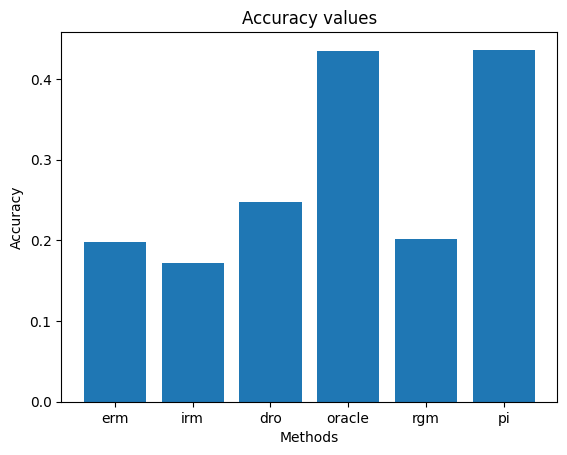

In [80]:
labels = list(dict_acc_values.keys())
values = list(dict_acc_values.values())

plt.bar(labels, values)
plt.title("Accuracy values")
plt.xlabel("Methods")
plt.ylabel("Accuracy")

plt.show()

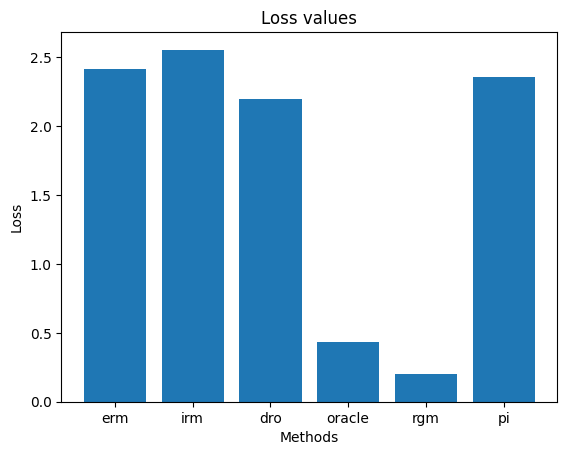

In [82]:
labels = list(dict_loss_values.keys())
values = list(dict_loss_values.values())

plt.bar(labels, values)
plt.title("Loss values")
plt.xlabel("Methods")
plt.ylabel("Loss")

plt.show()